Contexte du projet
L'épisode 3 a démontré que la technique de "transfer learning" pouvait augmenter de manière drastique les performances d'un CNN à effectuer de la classification d'images même sur un petit jeu de données. Il existe toutefois un léger sur-apprentissage résiduel. L'objectif de ce brief est de combiner la technique de "data augmentation" étudiée dans l'épisode 2 avec la technique de "features extraction" vue dans l'épisode 3 dans le but d'éliminer ce très léger sur-apprentissage résiduel ainsi que d'augmenter encore la précision du CNN.

Pour cela :

Charger à nouveau le modèle VGG-16
N.B. Ne pas oublier de "freezer" VGG-16 !
Concaténer VGG-16 avec par exemple le perceptron multi-couches suivant
​

model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(units=1, activation='sigmoid'))

​

N.B. Notons que l'architecture de ce MLP peut être optimisée : vous pouvez notamment tester un autre nombre de neurones dans la couche cachée.

​

Entrainer l'ensemble en utilisant la technique de "data augmentation"
ATTENTION AUX TEMPS DE CALCULS !!!

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import binary_crossentropy

In [26]:
# Spécifier les répertoires pour les données d'entraînement, de test et de validation
train_path = "/content/drive/MyDrive/Colab Notebooks/Data/Train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/Data/Validation"
test_path = "/content/drive/MyDrive/Colab Notebooks/Data/Test"

In [27]:
# Création de datasets au format approprié
train_ds = tf.keras.utils.image_dataset_from_directory(train_path, seed=123, image_size=(150, 150), batch_size=494)
valid_ds = tf.keras.utils.image_dataset_from_directory(valid_path, seed=123, image_size=(150, 150), batch_size=200)
test_ds = tf.keras.utils.image_dataset_from_directory(test_path, seed=123, image_size=(150, 150), batch_size=200)

Found 494 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [28]:
# Conversion en array Numpy
for image_batch, labels_batch in train_ds:
  X_train = np.array(image_batch)
  y_train = np.array(labels_batch)
  break

  # Conversion en array Numpy
for image_batch, labels_batch in valid_ds:
  X_valid = np.array(image_batch)
  y_valid = np.array(labels_batch)
  break

    # Conversion en array Numpy
for image_batch, labels_batch in test_ds:
  X_test = np.array(image_batch)
  y_test = np.array(labels_batch)
  break

In [29]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(494, 150, 150, 3)
(200, 150, 150, 3)
(200, 150, 150, 3)


In [30]:
# Prétraitement des images avec preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)
X_test = preprocess_input(X_test)

In [32]:
# Data Augmentation
image_width, image_height = 150,150

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,  # Taille de batch
    shuffle=True  # Vous pouvez activer ou désactiver la permutation des données
)


In [33]:
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet"
)

for layer in pre_trained_model.layers:
    layer.trainable=False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [34]:
model = tf.keras.models.Sequential([
    pre_trained_model,
    Flatten(),
    Dense(units=256, activation='relu', input_dim=4 * 4 * 512),
    Dense(units=1, activation='sigmoid')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nb_batch = 494  # Full batch

In [36]:
# Entrainement

history = model.fit(
    train_generator, # Données Générées
    epochs=100,
    validation_data=(X_valid, y_valid),  # Données de validation
    verbose=2  # Affichage des informations d'entraînement (0 pour aucun affichage, 1 pour barre de progression, 2 pour détails)
)

Epoch 1/100
16/16 - 6s - loss: 1.1754 - accuracy: 0.5830 - val_loss: 12.5358 - val_accuracy: 0.6850 - 6s/epoch - 347ms/step
Epoch 2/100
16/16 - 4s - loss: 0.4084 - accuracy: 0.8219 - val_loss: 14.5907 - val_accuracy: 0.7350 - 4s/epoch - 220ms/step
Epoch 3/100
16/16 - 4s - loss: 0.3157 - accuracy: 0.8704 - val_loss: 17.0034 - val_accuracy: 0.7400 - 4s/epoch - 271ms/step
Epoch 4/100
16/16 - 3s - loss: 0.2985 - accuracy: 0.8826 - val_loss: 15.3644 - val_accuracy: 0.7550 - 3s/epoch - 211ms/step
Epoch 5/100
16/16 - 3s - loss: 0.3137 - accuracy: 0.8603 - val_loss: 12.6034 - val_accuracy: 0.7700 - 3s/epoch - 209ms/step
Epoch 6/100
16/16 - 4s - loss: 0.2338 - accuracy: 0.9028 - val_loss: 14.6409 - val_accuracy: 0.7750 - 4s/epoch - 257ms/step
Epoch 7/100
16/16 - 3s - loss: 0.2251 - accuracy: 0.9150 - val_loss: 14.5701 - val_accuracy: 0.7850 - 3s/epoch - 209ms/step
Epoch 8/100
16/16 - 3s - loss: 0.2093 - accuracy: 0.9271 - val_loss: 16.2297 - val_accuracy: 0.7750 - 3s/epoch - 197ms/step
Epoch 9/

In [37]:
# Récupérez l'historique d'entraînement
history_df = pd.DataFrame(history.history)

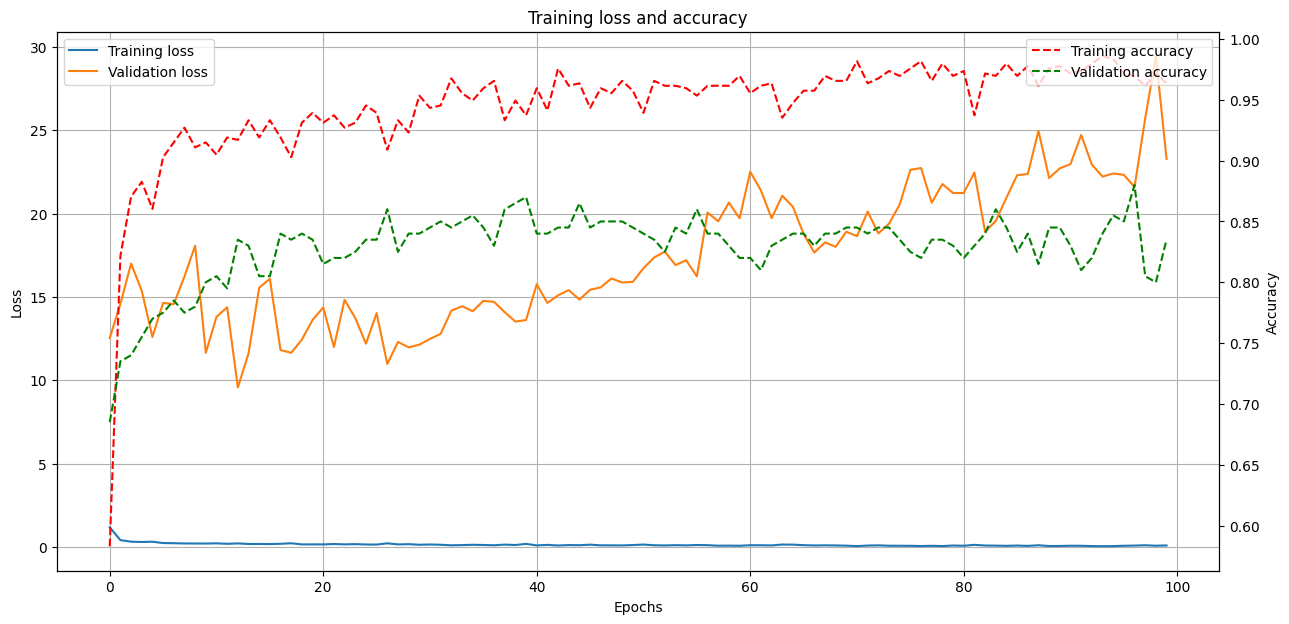

In [38]:
# Tracer la perte et l'exactitude d'entraînement
ax = history_df[['loss', 'val_loss']].plot(figsize=(15, 7))
ax2 = ax.twinx()
history_df[['accuracy', 'val_accuracy']].plot(ax=ax2, linestyle='dashed', color=['r', 'g'])
ax.grid()
_ = ax.set(title="Training loss and accuracy", xlabel="Epochs")
_ = ax.set_ylabel("Loss")
_ = ax2.set_ylabel("Accuracy")
_ = ax.legend(["Training loss", "Validation loss"], loc='upper left')
_ = ax2.legend(["Training accuracy", "Validation accuracy"], loc='upper right')
plt.show()

In [39]:
# Évaluez le modèle sur le jeu d'entraînement
train_scores = model.evaluate(X_train, y_train, verbose=0)
print("Scores sur le jeu d'entraînement:")
print("Loss: {:.4f}".format(train_scores[0]))
print("Accuracy: {:.2f}%".format(train_scores[1] * 100))

# Évaluez le modèle sur le jeu de validation
valid_scores = model.evaluate(X_valid, y_valid, verbose=0)
print("\nScores sur le jeu de validation:")
print("Loss: {:.4f}".format(valid_scores[0]))
print("Accuracy: {:.2f}%".format(valid_scores[1] * 100))

# Évaluez le modèle sur le jeu de test
test_scores = model.evaluate(X_valid, y_test, verbose=0)
print("\nScores sur le jeu de test:")
print("Loss: {:.4f}".format(test_scores[0]))
print("Accuracy: {:.2f}%".format(test_scores[1] * 100))

Scores sur le jeu d'entraînement:
Loss: 13.0366
Accuracy: 88.26%

Scores sur le jeu de validation:
Loss: 23.2715
Accuracy: 83.50%

Scores sur le jeu de test:
Loss: 23.2715
Accuracy: 83.50%


In [40]:
from sklearn.metrics import confusion_matrix

# Prédire les classes sur le jeu de test
y_pred = model.predict(X_test)

# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
confusion = confusion_matrix(y_test, y_pred_binary)

print("Matrice de confusion :")
print(confusion)

7/7 [==============================] - 1s 78ms/step
Matrice de confusion :
[[81 19]
 [ 3 97]]
